In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import params, trades, feats, plots, models_core
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)


<module 'libs.models_core' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models_core.py'>

In [2]:
# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
matplotlib.use("Agg")  # safe, headless-friendly
import matplotlib.pyplot as plt
plt.ioff()

import os
import json
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path

from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler, autocast

import optuna
from optuna.pruners import MedianPruner
from optuna.exceptions import TrialPruned
from optuna.importance import get_param_importances

from tqdm.auto import tqdm


In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['close_raw'] + [params.label_col]]
    
df_feat_sel

,sma_pct_14,atr_pct_14,rsi_14,bb_w_20,plus_di_14,range_pct,eng_ma,minus_di_14,macd_diff_12_26_9,ret,eng_macd,macd_line_12_26_9,obv_diff_14,eng_atr_div,eng_adx,hour,adx_14,close_raw,signal
2004-01-02 09:33:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.301415e-09
2004-01-02 09:34:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.405474e-09
2004-01-02 09:35:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.517855e-09
2004-01-02 09:36:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.639221e-09
2004-01-02 09:37:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.770291e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.751690,0.323886,0.672166,0.273759,0.363125,0.254109,0.532431,0.074852,0.888941,0.642346,0.634772,0.971125,1.000000,0.664288,0.537709,-0.975989,0.301944,196.815000,6.849078e-01
2025-06-18 20:57:00,0.650094,0.336016,0.616686,0.290460,0.347207,0.420131,0.532016,0.067044,0.840741,0.340442,0.633511,0.981544,0.000000,0.676887,0.541855,-0.975989,0.328685,196.675000,6.122057e-01
2025-06-18 20:58:00,0.631153,0.322169,0.614734,0.304199,0.336272,0.121620,0.531618,0.064933,0.777896,0.494192,0.631866,0.983006,0.000000,0.584662,0.545337,-0.975989,0.353515,196.670000,6.104678e-01
2025-06-18 20:59:00,0.375519,0.346959,0.475401,0.305249,0.290578,0.565110,0.531157,0.160021,0.456523,0.009795,0.623450,0.884486,0.000000,0.645760,0.531521,-0.975989,0.348960,196.240000,4.770902e-01


In [4]:
# calculate look_backs under half the interval between the day’s first and sess_start

first_time = (
    df_feat_sel.index
        .to_series()
        .groupby(df_feat_sel.index.normalize())
        .min()
        .dt.time
        .mode()[0]
)

# convert both times to minutes since midnight
fm = first_time.hour * 60 + first_time.minute
sm = params.sess_start.hour * 60 + params.sess_start.minute

# half the difference, count full 30-min slots, and build multiples
n_steps    = int(((sm - fm) / 2) // 30)      # e.g. floor(165/30) = 5
look_backs = [30 * i for i in range(1, n_steps + 1)]
look_backs


[30, 60, 90, 120]

In [5]:
# ──────────────────────────────────────────────────────────────────────────────
# Optuna objective definition
# ──────────────────────────────────────────────────────────────────────────────

look_backs = [60, 75, 90, 120]
    
def objective(trial):
    hp = {
        # ── Data & Windowing ────────────────────────────────────────────────
        "look_back":        trial.suggest_categorical("look_back", look_backs),

        # ── Architecture ───────────────────────────────────────────────────
        "SHORT_UNITS":      trial.suggest_categorical("SHORT_UNITS",[64, 96, 128]),    
        "LONG_UNITS":       trial.suggest_categorical("LONG_UNITS", [128, 192, 256]),  
        "DROPOUT_SHORT":    trial.suggest_float("DROPOUT_SHORT",    0.10, 0.40),          
        "DROPOUT_LONG":     trial.suggest_float("DROPOUT_LONG",     0.20, 0.50),          
        "ATT_HEADS":        trial.suggest_categorical("ATT_HEADS",  [8,    16]),      
        "ATT_DROPOUT":      trial.suggest_float("ATT_DROPOUT",      0.10, 0.40),          
        "CONV_K":           trial.suggest_int("CONV_K",             1,    5),            
        "CONV_DILATION":    trial.suggest_int("CONV_DILATION",      1,    3),              
        "SMOOTH_K":         trial.suggest_categorical("SMOOTH_K",   [3, 5, 7]),    
        "SMOOTH_DILATION":  trial.suggest_int("SMOOTH_DILATION",    1,    2),             

        # ── Optimizer & Scheduler ─────────────────────────────────────────
        "INITIAL_LR":       trial.suggest_float("INITIAL_LR",    1e-5,  3e-4,  log=True), 
        "ETA_MIN":          trial.suggest_float("ETA_MIN",       1e-7,  1e-5,  log=True),  
        "WEIGHT_DECAY":     trial.suggest_float("WEIGHT_DECAY",  1e-5,  1e-2,  log=True),  
        "CLIPNORM":         trial.suggest_float("CLIPNORM",      0.5,   3.0),          

        # ── Loss & Smoothing Weights ──────────────────────────────────────
        "CLS_LOSS_WEIGHT":  trial.suggest_float("CLS_LOSS_WEIGHT", 1e-3,   1e-0,  log=True), 
        "SMOOTH_ALPHA":     trial.suggest_float("SMOOTH_ALPHA",    1e-4,   5e-2,  log=True), 
        "SMOOTH_BETA":      trial.suggest_float("SMOOTH_BETA",     5.0,    50.0),         
        "SMOOTH_DELTA":     trial.suggest_float("SMOOTH_DELTA",    5e-4,   2e-2,  log=True),  
        "DIFF1_WEIGHT":     trial.suggest_float("DIFF1_WEIGHT",    0.0,    2.0),          
        "DIFF2_WEIGHT":     trial.suggest_float("DIFF2_WEIGHT",    0.0,    1.0),         
    }


    print(f"\n▶ Trial {trial.number} hyperparams:\n{hp}\n")

    # Compute session‐start adjusted for look_back
    hp_sess_start = dt.time(
        *divmod(
            (params.sess_start.hour * 60 + params.sess_start.minute) - hp["look_back"],
            60
        )
    )

    # Build data loaders
    train_loader, val_loader, test_loader, _, _, _ = models_core.model_core_pipeline(
        df               = df_feat_sel,
        look_back        = hp["look_back"],
        sess_start       = hp_sess_start,
        train_prop       = params.train_prop,
        val_prop         = params.val_prop,
        train_batch      = params.hparams["TRAIN_BATCH"],
        num_workers      = params.hparams["NUM_WORKERS"],
        prefetch_factor  = params.hparams["TRAIN_PREFETCH_FACTOR"],
        signal_thresh    = params.best_optuna_params["buy_threshold"],
        return_thresh    = params.return_threshold_tick
    )

    # Instantiate model with tunable architecture and smoothing
    model = params.model_selected.ModelClass(
        n_feats         = len(params.features_cols_tick),
        short_units     = hp["SHORT_UNITS"],
        long_units      = hp["LONG_UNITS"],
        dropout_short   = hp["DROPOUT_SHORT"],
        dropout_long    = hp["DROPOUT_LONG"],
        att_heads       = hp["ATT_HEADS"],
        att_drop        = hp["ATT_DROPOUT"],
        conv_k          = hp["CONV_K"],
        conv_dilation   = hp["CONV_DILATION"],
        smooth_k        = hp["SMOOTH_K"],
        smooth_dilation = hp["SMOOTH_DILATION"]
    ).to(params.device)

    # Build optimizer, schedulers, scaler
    optimizer, plateau_sched, _, scaler, _clipnorm = \
        models_core.make_optimizer_and_scheduler(
            model        = model,
            initial_lr   = hp["INITIAL_LR"],
            weight_decay = hp["WEIGHT_DECAY"],
            clipnorm     = hp["CLIPNORM"]
        )
    cosine_sched = CosineAnnealingWarmRestarts(
        optimizer,
        T_0    = params.hparams['T_0'],
        T_mult = params.hparams['T_MULT'],
        eta_min= hp['ETA_MIN']
    )

    # Run the custom training loop with direct loss‐weight args
    best_val_rmse = params.model_selected.model_training_loop(
        model               = model,
        optimizer           = optimizer,
        cosine_sched        = cosine_sched,
        plateau_sched       = plateau_sched,
        scaler              = scaler,
        train_loader        = train_loader,
        val_loader          = val_loader,
        max_epochs          = params.hparams['MAX_EPOCHS'],
        early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
        clipnorm            = hp["CLIPNORM"],
        device              = params.device,

        # Tunable loss & smoothing weights
        cls_loss_weight     = hp["CLS_LOSS_WEIGHT"],
        smooth_alpha        = hp["SMOOTH_ALPHA"],
        smooth_beta         = hp["SMOOTH_BETA"],
        smooth_delta        = hp["SMOOTH_DELTA"],
        diff1_weight        = hp["DIFF1_WEIGHT"],
        diff2_weight        = hp["DIFF2_WEIGHT"],
    )

    # Clean up
    del model, optimizer, plateau_sched, cosine_sched, scaler
    del train_loader, val_loader, test_loader
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return best_val_rmse


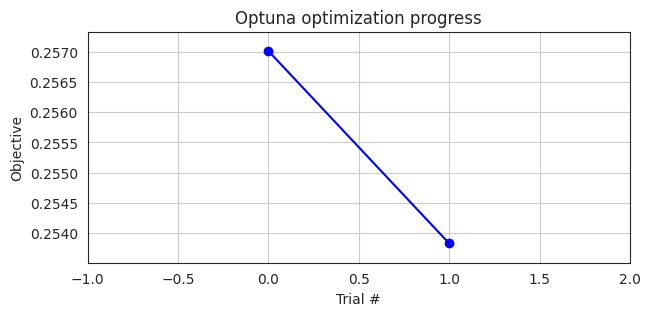

In [6]:
# build blank figure & line
fig, ax = plt.subplots(figsize=(7,3))
line, = ax.plot([], [], "bo-")
ax.set(xlabel="Trial #", ylabel="Objective",
       title="Optuna optimization progress")
ax.grid(True)

# display once and grab the handle
handle = display(fig, display_id=True)
plt.close(fig)

# ask plots.py for a callback bound to these objects
live_cb = plots.make_live_plot_callback(fig, ax, line, handle)

[I 2025-10-02 21:25:23,587] A new study created in RDB with name: no-name-75401047-c928-4c20-ba25-736ff556ae0b



▶ Trial 0 hyperparams:
{'look_back': 75, 'SHORT_UNITS': 64, 'LONG_UNITS': 128, 'DROPOUT_SHORT': 0.10792442730164706, 'DROPOUT_LONG': 0.2722214865737726, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.18926553707328364, 'CONV_K': 5, 'CONV_DILATION': 2, 'SMOOTH_K': 5, 'SMOOTH_DILATION': 1, 'INITIAL_LR': 2.4103400123014883e-05, 'ETA_MIN': 6.647957818533235e-06, 'WEIGHT_DECAY': 1.5934056612591538e-05, 'CLIPNORM': 2.723429290248059, 'CLS_LOSS_WEIGHT': 0.0016006670829637063, 'SMOOTH_ALPHA': 0.00023689986426958626, 'SMOOTH_BETA': 29.791269860996426, 'SMOOTH_DELTA': 0.004711165093953135, 'DIFF1_WEIGHT': 0.7826754612979765, 'DIFF2_WEIGHT': 0.905533688341287}

Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

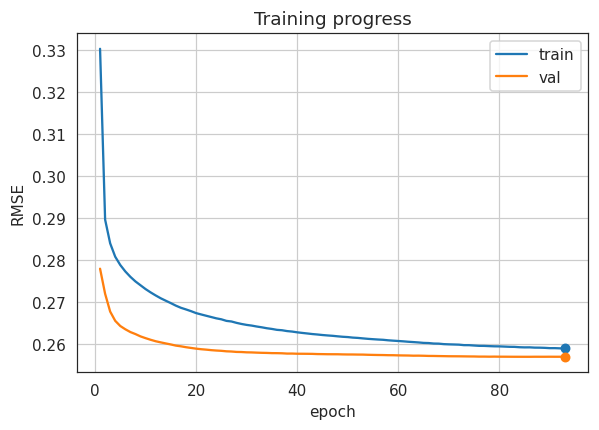

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.33030 MAE=0.28953 R2=-0.29533 | Acc=0.59237 Prec=0.28855 Rec=0.33082 F1=0.30824 AUROC=0.51199 | T_ACC=0.35882 T_P=0.33337 T_R=0.35882 T_F1=0.05566 T_AUC=0.62591
VALID→ RMSE=0.27798 MAE=0.21532 R2=0.05762 | Acc=0.71583 Prec=0.48148 Rec=0.00039 F1=0.00078 AUROC=0.39018 | T_ACC=0.33336 T_P=0.33337 T_R=0.33336 T_F1=0.00011 T_AUC=0.71726


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.28966 MAE=0.23600 R2=0.00376 | Acc=0.65929 Prec=0.29657 Rec=0.17575 F1=0.22071 AUROC=0.51265 | T_ACC=0.33419 T_P=0.33336 T_R=0.33419 T_F1=0.02111 T_AUC=0.61626
VALID→ RMSE=0.27202 MAE=0.20627 R2=0.09762 | Acc=0.71583 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.41758 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.69524


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.28401 MAE=0.22830 R2=0.04225 | Acc=0.69222 Prec=0.30399 Rec=0.09393 F1=0.14351 AUROC=0.51305 | T_ACC=0.33626 T_P=0.33336 T_R=0.33626 T_F1=0.01193 T_AUC=0.61887
VALID→ RMSE=0.26778 MAE=0.20306 R2=0.12552 | Acc=0.71584 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.44452 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.69032


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.28083 MAE=0.22554 R2=0.06362 | Acc=0.70624 Prec=0.31426 Rec=0.05926 F1=0.09972 AUROC=0.51670 | T_ACC=0.33556 T_P=0.33338 T_R=0.33556 T_F1=0.00857 T_AUC=0.60882
VALID→ RMSE=0.26558 MAE=0.20179 R2=0.13983 | Acc=0.71584 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.46950 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.69028


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.27886 MAE=0.22402 R2=0.07671 | Acc=0.71314 Prec=0.32433 Rec=0.04148 F1=0.07355 AUROC=0.51985 | T_ACC=0.33437 T_P=0.33334 T_R=0.33437 T_F1=0.00692 T_AUC=0.62399
VALID→ RMSE=0.26435 MAE=0.20119 R2=0.14779 | Acc=0.71584 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.49376 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.69254


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.27732 MAE=0.22302 R2=0.08685 | Acc=0.71707 Prec=0.33615 Rec=0.03140 F1=0.05743 AUROC=0.52441 | T_ACC=0.33768 T_P=0.33337 T_R=0.33768 T_F1=0.00596 T_AUC=0.61033
VALID→ RMSE=0.26357 MAE=0.20081 R2=0.15281 | Acc=0.71584 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.51702 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.69599


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.27604 MAE=0.22223 R2=0.09525 | Acc=0.71959 Prec=0.34994 Rec=0.02499 F1=0.04666 AUROC=0.52899 | T_ACC=0.33448 T_P=0.33336 T_R=0.33448 T_F1=0.00510 T_AUC=0.61295
VALID→ RMSE=0.26290 MAE=0.20065 R2=0.15706 | Acc=0.71584 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.53995 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.69914


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.27495 MAE=0.22153 R2=0.10241 | Acc=0.72134 Prec=0.36793 Rec=0.02099 F1=0.03971 AUROC=0.53413 | T_ACC=0.33147 T_P=0.33336 T_R=0.33147 T_F1=0.00459 T_AUC=0.61350
VALID→ RMSE=0.26243 MAE=0.20038 R2=0.16012 | Acc=0.71584 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.56229 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70148


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.27404 MAE=0.22107 R2=0.10833 | Acc=0.72236 Prec=0.37995 Rec=0.01800 F1=0.03436 AUROC=0.53818 | T_ACC=0.33513 T_P=0.33337 T_R=0.33513 T_F1=0.00433 T_AUC=0.58133
VALID→ RMSE=0.26187 MAE=0.20039 R2=0.16366 | Acc=0.71584 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.58314 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70304


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.27313 MAE=0.22063 R2=0.11422 | Acc=0.72326 Prec=0.40105 Rec=0.01636 F1=0.03145 AUROC=0.54305 | T_ACC=0.33458 T_P=0.33338 T_R=0.33458 T_F1=0.00392 T_AUC=0.60013
VALID→ RMSE=0.26146 MAE=0.20031 R2=0.16632 | Acc=0.71584 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.60206 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70405


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.27234 MAE=0.22024 R2=0.11934 | Acc=0.72358 Prec=0.40428 Rec=0.01461 F1=0.02820 AUROC=0.54870 | T_ACC=0.32859 T_P=0.33337 T_R=0.32859 T_F1=0.00368 T_AUC=0.59610
VALID→ RMSE=0.26107 MAE=0.20021 R2=0.16879 | Acc=0.71584 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.61933 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70512


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.27162 MAE=0.21994 R2=0.12402 | Acc=0.72432 Prec=0.43531 Rec=0.01421 F1=0.02753 AUROC=0.55409 | T_ACC=0.33606 T_P=0.33339 T_R=0.33606 T_F1=0.00346 T_AUC=0.59054
VALID→ RMSE=0.26072 MAE=0.20022 R2=0.17101 | Acc=0.71584 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.63465 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70605


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.27094 MAE=0.21966 R2=0.12837 | Acc=0.72447 Prec=0.44073 Rec=0.01370 F1=0.02657 AUROC=0.55952 | T_ACC=0.33631 T_P=0.33338 T_R=0.33631 T_F1=0.00326 T_AUC=0.60231
VALID→ RMSE=0.26045 MAE=0.20022 R2=0.17272 | Acc=0.71584 Prec=0.00000 Rec=0.00000 F1=0.00000 AUROC=0.64761 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70695


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.27036 MAE=0.21941 R2=0.13211 | Acc=0.72482 Prec=0.45911 Rec=0.01352 F1=0.02626 AUROC=0.56472 | T_ACC=0.33488 T_P=0.33336 T_R=0.33488 T_F1=0.00314 T_AUC=0.62066
VALID→ RMSE=0.26020 MAE=0.20025 R2=0.17433 | Acc=0.71584 Prec=1.00000 Rec=0.00001 F1=0.00002 AUROC=0.65843 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70775


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.26979 MAE=0.21917 R2=0.13578 | Acc=0.72515 Prec=0.47908 Rec=0.01357 F1=0.02639 AUROC=0.56983 | T_ACC=0.33446 T_P=0.33337 T_R=0.33446 T_F1=0.00301 T_AUC=0.60319
VALID→ RMSE=0.25995 MAE=0.20034 R2=0.17588 | Acc=0.71584 Prec=1.00000 Rec=0.00001 F1=0.00002 AUROC=0.66788 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70848


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ RMSE=0.26919 MAE=0.21893 R2=0.13963 | Acc=0.72544 Prec=0.49768 Rec=0.01419 F1=0.02760 AUROC=0.57569 | T_ACC=0.33821 T_P=0.33338 T_R=0.33821 T_F1=0.00293 T_AUC=0.60509
VALID→ RMSE=0.25968 MAE=0.20050 R2=0.17760 | Acc=0.71585 Prec=1.00000 Rec=0.00004 F1=0.00008 AUROC=0.67599 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70908


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ RMSE=0.26868 MAE=0.21874 R2=0.14289 | Acc=0.72564 Prec=0.51077 Rec=0.01453 F1=0.02825 AUROC=0.58111 | T_ACC=0.33469 T_P=0.33336 T_R=0.33469 T_F1=0.00276 T_AUC=0.59966
VALID→ RMSE=0.25951 MAE=0.20060 R2=0.17867 | Acc=0.71585 Prec=0.85714 Rec=0.00006 F1=0.00012 AUROC=0.68247 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70949


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ RMSE=0.26829 MAE=0.21860 R2=0.14537 | Acc=0.72578 Prec=0.51943 Rec=0.01488 F1=0.02894 AUROC=0.58595 | T_ACC=0.33426 T_P=0.33338 T_R=0.33426 T_F1=0.00262 T_AUC=0.59041
VALID→ RMSE=0.25930 MAE=0.20076 R2=0.18002 | Acc=0.71586 Prec=0.90909 Rec=0.00010 F1=0.00020 AUROC=0.68832 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.71035


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ RMSE=0.26788 MAE=0.21857 R2=0.14799 | Acc=0.72613 Prec=0.53989 Rec=0.01613 F1=0.03133 AUROC=0.59191 | T_ACC=0.33046 T_P=0.33331 T_R=0.33046 T_F1=0.00258 T_AUC=0.58840
VALID→ RMSE=0.25913 MAE=0.20081 R2=0.18110 | Acc=0.71587 Prec=0.83333 Rec=0.00015 F1=0.00030 AUROC=0.69344 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.71067


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ RMSE=0.26741 MAE=0.21828 R2=0.15093 | Acc=0.72641 Prec=0.55567 Rec=0.01693 F1=0.03285 AUROC=0.59726 | T_ACC=0.33596 T_P=0.33334 T_R=0.33596 T_F1=0.00260 T_AUC=0.60457
VALID→ RMSE=0.25896 MAE=0.20095 R2=0.18218 | Acc=0.71591 Prec=0.83333 Rec=0.00030 F1=0.00060 AUROC=0.69796 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.71100


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ RMSE=0.26709 MAE=0.21825 R2=0.15296 | Acc=0.72633 Prec=0.54932 Rec=0.01732 F1=0.03358 AUROC=0.60195 | T_ACC=0.33450 T_P=0.33336 T_R=0.33450 T_F1=0.00239 T_AUC=0.60393
VALID→ RMSE=0.25882 MAE=0.20111 R2=0.18303 | Acc=0.71598 Prec=0.86567 Rec=0.00058 F1=0.00117 AUROC=0.70181 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.71136


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ RMSE=0.26678 MAE=0.21816 R2=0.15493 | Acc=0.72678 Prec=0.57137 Rec=0.01908 F1=0.03692 AUROC=0.60695 | T_ACC=0.33623 T_P=0.33338 T_R=0.33623 T_F1=0.00243 T_AUC=0.61221
VALID→ RMSE=0.25872 MAE=0.20125 R2=0.18366 | Acc=0.71605 Prec=0.86869 Rec=0.00086 F1=0.00173 AUROC=0.70546 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.71203


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ RMSE=0.26648 MAE=0.21808 R2=0.15687 | Acc=0.72713 Prec=0.58582 Rec=0.02051 F1=0.03963 AUROC=0.61159 | T_ACC=0.33240 T_P=0.33336 T_R=0.33240 T_F1=0.00232 T_AUC=0.59010
VALID→ RMSE=0.25860 MAE=0.20141 R2=0.18444 | Acc=0.71618 Prec=0.87342 Rec=0.00139 F1=0.00277 AUROC=0.70878 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.71245


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ RMSE=0.26617 MAE=0.21795 R2=0.15881 | Acc=0.72748 Prec=0.59846 Rec=0.02222 F1=0.04284 AUROC=0.61577 | T_ACC=0.32997 T_P=0.33338 T_R=0.32997 T_F1=0.00233 T_AUC=0.60408
VALID→ RMSE=0.25851 MAE=0.20152 R2=0.18502 | Acc=0.71633 Prec=0.88789 Rec=0.00199 F1=0.00397 AUROC=0.71175 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.71284


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ RMSE=0.26594 MAE=0.21789 R2=0.16028 | Acc=0.72765 Prec=0.59990 Rec=0.02382 F1=0.04582 AUROC=0.62017 | T_ACC=0.33444 T_P=0.33336 T_R=0.33444 T_F1=0.00226 T_AUC=0.58043
VALID→ RMSE=0.25844 MAE=0.20156 R2=0.18545 | Acc=0.71651 Prec=0.87540 Rec=0.00276 F1=0.00549 AUROC=0.71452 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.71283


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ RMSE=0.26556 MAE=0.21759 R2=0.16263 | Acc=0.72789 Prec=0.60390 Rec=0.02559 F1=0.04910 AUROC=0.62500 | T_ACC=0.33441 T_P=0.33336 T_R=0.33441 T_F1=0.00221 T_AUC=0.59698
VALID→ RMSE=0.25832 MAE=0.20184 R2=0.18618 | Acc=0.71675 Prec=0.87886 Rec=0.00372 F1=0.00741 AUROC=0.71716 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.71300


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ RMSE=0.26542 MAE=0.21769 R2=0.16355 | Acc=0.72833 Prec=0.61529 Rec=0.02769 F1=0.05299 AUROC=0.62941 | T_ACC=0.33231 T_P=0.33336 T_R=0.33231 T_F1=0.00215 T_AUC=0.60067
VALID→ RMSE=0.25827 MAE=0.20187 R2=0.18649 | Acc=0.71702 Prec=0.86702 Rec=0.00492 F1=0.00978 AUROC=0.71947 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.71313


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ RMSE=0.26509 MAE=0.21739 R2=0.16561 | Acc=0.72877 Prec=0.62336 Rec=0.03036 F1=0.05789 AUROC=0.63363 | T_ACC=0.33227 T_P=0.33336 T_R=0.33227 T_F1=0.00207 T_AUC=0.59514
VALID→ RMSE=0.25818 MAE=0.20194 R2=0.18710 | Acc=0.71737 Prec=0.85638 Rec=0.00648 F1=0.01285 AUROC=0.72169 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.71292


Epoch 29:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ RMSE=0.26483 MAE=0.21725 R2=0.16728 | Acc=0.72919 Prec=0.63180 Rec=0.03242 F1=0.06168 AUROC=0.63702 | T_ACC=0.33774 T_P=0.33341 T_R=0.33774 T_F1=0.00205 T_AUC=0.59595
VALID→ RMSE=0.25815 MAE=0.20211 R2=0.18725 | Acc=0.71778 Prec=0.86373 Rec=0.00809 F1=0.01604 AUROC=0.72358 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.71265


Epoch 30:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ RMSE=0.26461 MAE=0.21710 R2=0.16866 | Acc=0.72959 Prec=0.63672 Rec=0.03485 F1=0.06609 AUROC=0.64024 | T_ACC=0.33599 T_P=0.33339 T_R=0.33599 T_F1=0.00196 T_AUC=0.59867
VALID→ RMSE=0.25808 MAE=0.20227 R2=0.18771 | Acc=0.71824 Prec=0.86419 Rec=0.01005 F1=0.01986 AUROC=0.72543 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.71221


Epoch 31:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ RMSE=0.26444 MAE=0.21705 R2=0.16969 | Acc=0.72998 Prec=0.64000 Rec=0.03747 F1=0.07079 AUROC=0.64494 | T_ACC=0.33424 T_P=0.33336 T_R=0.33424 T_F1=0.00186 T_AUC=0.60915
VALID→ RMSE=0.25806 MAE=0.20234 R2=0.18785 | Acc=0.71876 Prec=0.85976 Rec=0.01227 F1=0.02419 AUROC=0.72698 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.71173


Epoch 32:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ RMSE=0.26422 MAE=0.21686 R2=0.17108 | Acc=0.73026 Prec=0.64008 Rec=0.03982 F1=0.07498 AUROC=0.64779 | T_ACC=0.33423 T_P=0.33336 T_R=0.33423 T_F1=0.00184 T_AUC=0.60023
VALID→ RMSE=0.25801 MAE=0.20249 R2=0.18817 | Acc=0.71926 Prec=0.85911 Rec=0.01441 F1=0.02834 AUROC=0.72861 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.71121


Epoch 33:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ RMSE=0.26403 MAE=0.21677 R2=0.17226 | Acc=0.73079 Prec=0.64686 Rec=0.04263 F1=0.07999 AUROC=0.65122 | T_ACC=0.33212 T_P=0.33336 T_R=0.33212 T_F1=0.00177 T_AUC=0.58953
VALID→ RMSE=0.25796 MAE=0.20250 R2=0.18843 | Acc=0.71978 Prec=0.85197 Rec=0.01678 F1=0.03292 AUROC=0.73011 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.71072


Epoch 34:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ RMSE=0.26381 MAE=0.21654 R2=0.17365 | Acc=0.73138 Prec=0.65323 Rec=0.04580 F1=0.08561 AUROC=0.65432 | T_ACC=0.33416 T_P=0.33336 T_R=0.33416 T_F1=0.00172 T_AUC=0.59123
VALID→ RMSE=0.25794 MAE=0.20260 R2=0.18859 | Acc=0.72034 Prec=0.84427 Rec=0.01941 F1=0.03794 AUROC=0.73145 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.71007


Epoch 35:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 035
TRAIN→ RMSE=0.26365 MAE=0.21646 R2=0.17469 | Acc=0.73181 Prec=0.65593 Rec=0.04853 F1=0.09037 AUROC=0.65827 | T_ACC=0.33413 T_P=0.33336 T_R=0.33413 T_F1=0.00166 T_AUC=0.59786
VALID→ RMSE=0.25789 MAE=0.20268 R2=0.18889 | Acc=0.72088 Prec=0.84358 Rec=0.02180 F1=0.04250 AUROC=0.73272 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70940


Epoch 36:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 036
TRAIN→ RMSE=0.26343 MAE=0.21625 R2=0.17604 | Acc=0.73222 Prec=0.65718 Rec=0.05135 F1=0.09526 AUROC=0.66063 | T_ACC=0.33412 T_P=0.33336 T_R=0.33412 T_F1=0.00164 T_AUC=0.60013
VALID→ RMSE=0.25788 MAE=0.20288 R2=0.18895 | Acc=0.72147 Prec=0.83390 Rec=0.02474 F1=0.04805 AUROC=0.73393 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70891


Epoch 37:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 037
TRAIN→ RMSE=0.26334 MAE=0.21624 R2=0.17662 | Acc=0.73276 Prec=0.66115 Rec=0.05441 F1=0.10055 AUROC=0.66350 | T_ACC=0.33411 T_P=0.33328 T_R=0.33411 T_F1=0.00162 T_AUC=0.59056
VALID→ RMSE=0.25785 MAE=0.20289 R2=0.18914 | Acc=0.72203 Prec=0.83124 Rec=0.02734 F1=0.05294 AUROC=0.73506 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70847


Epoch 38:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 038
TRAIN→ RMSE=0.26314 MAE=0.21606 R2=0.17788 | Acc=0.73338 Prec=0.66613 Rec=0.05770 F1=0.10620 AUROC=0.66701 | T_ACC=0.33201 T_P=0.33336 T_R=0.33201 T_F1=0.00156 T_AUC=0.59086
VALID→ RMSE=0.25778 MAE=0.20305 R2=0.18957 | Acc=0.72277 Prec=0.82842 Rec=0.03078 F1=0.05936 AUROC=0.73612 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70832


Epoch 39:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 039
TRAIN→ RMSE=0.26302 MAE=0.21602 R2=0.17860 | Acc=0.73396 Prec=0.66808 Rec=0.06141 F1=0.11248 AUROC=0.66878 | T_ACC=0.33405 T_P=0.33336 T_R=0.33405 T_F1=0.00149 T_AUC=0.59917
VALID→ RMSE=0.25779 MAE=0.20309 R2=0.18955 | Acc=0.72341 Prec=0.82571 Rec=0.03378 F1=0.06490 AUROC=0.73705 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70794


Epoch 40:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 040
TRAIN→ RMSE=0.26284 MAE=0.21583 R2=0.17972 | Acc=0.73424 Prec=0.66644 Rec=0.06390 F1=0.11661 AUROC=0.67144 | T_ACC=0.33198 T_P=0.33336 T_R=0.33198 T_F1=0.00149 T_AUC=0.61265
VALID→ RMSE=0.25774 MAE=0.20317 R2=0.18982 | Acc=0.72408 Prec=0.81897 Rec=0.03726 F1=0.07127 AUROC=0.73793 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70744


Epoch 41:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 041
TRAIN→ RMSE=0.26270 MAE=0.21576 R2=0.18060 | Acc=0.73470 Prec=0.66743 Rec=0.06700 F1=0.12177 AUROC=0.67380 | T_ACC=0.33402 T_P=0.33336 T_R=0.33402 T_F1=0.00143 T_AUC=0.58511
VALID→ RMSE=0.25774 MAE=0.20325 R2=0.18985 | Acc=0.72477 Prec=0.81798 Rec=0.04044 F1=0.07708 AUROC=0.73881 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70722


Epoch 42:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 042
TRAIN→ RMSE=0.26257 MAE=0.21562 R2=0.18142 | Acc=0.73523 Prec=0.66776 Rec=0.07068 F1=0.12782 AUROC=0.67631 | T_ACC=0.33194 T_P=0.33336 T_R=0.33194 T_F1=0.00141 T_AUC=0.57625
VALID→ RMSE=0.25773 MAE=0.20333 R2=0.18991 | Acc=0.72533 Prec=0.81105 Rec=0.04355 F1=0.08266 AUROC=0.73959 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70705


Epoch 43:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 043
TRAIN→ RMSE=0.26243 MAE=0.21549 R2=0.18229 | Acc=0.73601 Prec=0.67524 Rec=0.07392 F1=0.13325 AUROC=0.67788 | T_ACC=0.33400 T_P=0.33336 T_R=0.33400 T_F1=0.00139 T_AUC=0.59144
VALID→ RMSE=0.25771 MAE=0.20340 R2=0.19002 | Acc=0.72598 Prec=0.80752 Rec=0.04687 F1=0.08860 AUROC=0.74038 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70687


Epoch 44:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 044
TRAIN→ RMSE=0.26232 MAE=0.21543 R2=0.18295 | Acc=0.73655 Prec=0.67649 Rec=0.07732 F1=0.13877 AUROC=0.68038 | T_ACC=0.33400 T_P=0.33336 T_R=0.33400 T_F1=0.00140 T_AUC=0.58822
VALID→ RMSE=0.25767 MAE=0.20340 R2=0.19030 | Acc=0.72653 Prec=0.80367 Rec=0.04981 F1=0.09380 AUROC=0.74111 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70666


Epoch 45:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 045
TRAIN→ RMSE=0.26220 MAE=0.21532 R2=0.18372 | Acc=0.73695 Prec=0.67487 Rec=0.08068 F1=0.14413 AUROC=0.68218 | T_ACC=0.33400 T_P=0.33336 T_R=0.33400 T_F1=0.00139 T_AUC=0.58394
VALID→ RMSE=0.25765 MAE=0.20351 R2=0.19040 | Acc=0.72717 Prec=0.80036 Rec=0.05313 F1=0.09965 AUROC=0.74175 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70645


Epoch 46:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 046
TRAIN→ RMSE=0.26210 MAE=0.21525 R2=0.18435 | Acc=0.73721 Prec=0.67434 Rec=0.08263 F1=0.14722 AUROC=0.68424 | T_ACC=0.33399 T_P=0.33336 T_R=0.33399 T_F1=0.00137 T_AUC=0.60444
VALID→ RMSE=0.25763 MAE=0.20361 R2=0.19054 | Acc=0.72789 Prec=0.79972 Rec=0.05657 F1=0.10567 AUROC=0.74237 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70640


Epoch 47:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 047
TRAIN→ RMSE=0.26201 MAE=0.21523 R2=0.18489 | Acc=0.73779 Prec=0.67469 Rec=0.08663 F1=0.15354 AUROC=0.68682 | T_ACC=0.33400 T_P=0.33336 T_R=0.33400 T_F1=0.00138 T_AUC=0.59735
VALID→ RMSE=0.25762 MAE=0.20365 R2=0.19057 | Acc=0.72851 Prec=0.79788 Rec=0.05974 F1=0.11116 AUROC=0.74297 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70630


Epoch 48:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 048
TRAIN→ RMSE=0.26189 MAE=0.21514 R2=0.18564 | Acc=0.73838 Prec=0.67708 Rec=0.08989 F1=0.15871 AUROC=0.68863 | T_ACC=0.33400 T_P=0.33336 T_R=0.33400 T_F1=0.00138 T_AUC=0.59378
VALID→ RMSE=0.25762 MAE=0.20364 R2=0.19060 | Acc=0.72902 Prec=0.79324 Rec=0.06273 F1=0.11626 AUROC=0.74347 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70595


Epoch 49:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 049
TRAIN→ RMSE=0.26178 MAE=0.21500 R2=0.18631 | Acc=0.73900 Prec=0.67985 Rec=0.09313 F1=0.16382 AUROC=0.68997 | T_ACC=0.33398 T_P=0.33327 T_R=0.33398 T_F1=0.00135 T_AUC=0.59084
VALID→ RMSE=0.25759 MAE=0.20380 R2=0.19080 | Acc=0.72974 Prec=0.79226 Rec=0.06631 F1=0.12237 AUROC=0.74399 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70596


Epoch 50:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 050
TRAIN→ RMSE=0.26171 MAE=0.21500 R2=0.18676 | Acc=0.73935 Prec=0.67803 Rec=0.09620 F1=0.16849 AUROC=0.69071 | T_ACC=0.33189 T_P=0.33336 T_R=0.33189 T_F1=0.00131 T_AUC=0.58666
VALID→ RMSE=0.25757 MAE=0.20371 R2=0.19092 | Acc=0.73027 Prec=0.79068 Rec=0.06909 F1=0.12708 AUROC=0.74444 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70572


Epoch 51:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 051
TRAIN→ RMSE=0.26158 MAE=0.21484 R2=0.18755 | Acc=0.73978 Prec=0.67719 Rec=0.09953 F1=0.17355 AUROC=0.69347 | T_ACC=0.33396 T_P=0.33336 T_R=0.33396 T_F1=0.00132 T_AUC=0.59183
VALID→ RMSE=0.25757 MAE=0.20384 R2=0.19094 | Acc=0.73079 Prec=0.78819 Rec=0.07196 F1=0.13188 AUROC=0.74490 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70572


Epoch 52:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 052
TRAIN→ RMSE=0.26151 MAE=0.21481 R2=0.18799 | Acc=0.74037 Prec=0.68188 Rec=0.10170 F1=0.17700 AUROC=0.69436 | T_ACC=0.33396 T_P=0.33336 T_R=0.33396 T_F1=0.00132 T_AUC=0.59670
VALID→ RMSE=0.25755 MAE=0.20383 R2=0.19106 | Acc=0.73124 Prec=0.78422 Rec=0.07477 F1=0.13653 AUROC=0.74536 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70573


Epoch 53:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 053
TRAIN→ RMSE=0.26140 MAE=0.21468 R2=0.18870 | Acc=0.74076 Prec=0.68007 Rec=0.10514 F1=0.18213 AUROC=0.69604 | T_ACC=0.33188 T_P=0.33316 T_R=0.33188 T_F1=0.00129 T_AUC=0.58406
VALID→ RMSE=0.25754 MAE=0.20388 R2=0.19111 | Acc=0.73185 Prec=0.78274 Rec=0.07800 F1=0.14187 AUROC=0.74577 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70574


Epoch 54:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 054
TRAIN→ RMSE=0.26129 MAE=0.21458 R2=0.18937 | Acc=0.74117 Prec=0.67976 Rec=0.10807 F1=0.18650 AUROC=0.69755 | T_ACC=0.33396 T_P=0.33336 T_R=0.33396 T_F1=0.00130 T_AUC=0.60006
VALID→ RMSE=0.25750 MAE=0.20398 R2=0.19138 | Acc=0.73247 Prec=0.78140 Rec=0.08127 F1=0.14723 AUROC=0.74619 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70562


Epoch 55:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 055
TRAIN→ RMSE=0.26121 MAE=0.21455 R2=0.18990 | Acc=0.74150 Prec=0.67897 Rec=0.11072 F1=0.19039 AUROC=0.69902 | T_ACC=0.33396 T_P=0.33336 T_R=0.33396 T_F1=0.00131 T_AUC=0.58119
VALID→ RMSE=0.25747 MAE=0.20398 R2=0.19154 | Acc=0.73305 Prec=0.78017 Rec=0.08433 F1=0.15220 AUROC=0.74654 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70559


Epoch 56:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 056
TRAIN→ RMSE=0.26113 MAE=0.21445 R2=0.19039 | Acc=0.74226 Prec=0.68212 Rec=0.11449 F1=0.19608 AUROC=0.70014 | T_ACC=0.33395 T_P=0.33336 T_R=0.33395 T_F1=0.00129 T_AUC=0.57103
VALID→ RMSE=0.25745 MAE=0.20401 R2=0.19170 | Acc=0.73352 Prec=0.77746 Rec=0.08719 F1=0.15680 AUROC=0.74685 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70557


Epoch 57:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 057
TRAIN→ RMSE=0.26106 MAE=0.21440 R2=0.19078 | Acc=0.74246 Prec=0.67946 Rec=0.11709 F1=0.19976 AUROC=0.70122 | T_ACC=0.33394 T_P=0.33336 T_R=0.33394 T_F1=0.00127 T_AUC=0.57156
VALID→ RMSE=0.25743 MAE=0.20411 R2=0.19178 | Acc=0.73395 Prec=0.77434 Rec=0.08996 F1=0.16119 AUROC=0.74717 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70570


Epoch 58:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 058
TRAIN→ RMSE=0.26094 MAE=0.21430 R2=0.19152 | Acc=0.74292 Prec=0.67993 Rec=0.12009 F1=0.20412 AUROC=0.70276 | T_ACC=0.33569 T_P=0.33342 T_R=0.33569 T_F1=0.00141 T_AUC=0.59273
VALID→ RMSE=0.25740 MAE=0.20408 R2=0.19198 | Acc=0.73427 Prec=0.77094 Rec=0.09229 F1=0.16485 AUROC=0.74746 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70568


Epoch 59:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 059
TRAIN→ RMSE=0.26086 MAE=0.21418 R2=0.19206 | Acc=0.74337 Prec=0.68124 Rec=0.12250 F1=0.20765 AUROC=0.70348 | T_ACC=0.33394 T_P=0.33326 T_R=0.33394 T_F1=0.00127 T_AUC=0.57198
VALID→ RMSE=0.25739 MAE=0.20418 R2=0.19204 | Acc=0.73486 Prec=0.76995 Rec=0.09545 F1=0.16984 AUROC=0.74770 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70566


Epoch 60:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 060
TRAIN→ RMSE=0.26078 MAE=0.21414 R2=0.19255 | Acc=0.74374 Prec=0.68015 Rec=0.12558 F1=0.21202 AUROC=0.70487 | T_ACC=0.33394 T_P=0.33336 T_R=0.33394 T_F1=0.00128 T_AUC=0.59392
VALID→ RMSE=0.25736 MAE=0.20417 R2=0.19225 | Acc=0.73541 Prec=0.76926 Rec=0.09839 F1=0.17447 AUROC=0.74797 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70577


Epoch 61:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 061
TRAIN→ RMSE=0.26070 MAE=0.21400 R2=0.19306 | Acc=0.74409 Prec=0.67927 Rec=0.12842 F1=0.21601 AUROC=0.70581 | T_ACC=0.33565 T_P=0.33342 T_R=0.33565 T_F1=0.00135 T_AUC=0.60078
VALID→ RMSE=0.25734 MAE=0.20423 R2=0.19238 | Acc=0.73575 Prec=0.76679 Rec=0.10068 F1=0.17798 AUROC=0.74824 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70558


Epoch 62:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 062
TRAIN→ RMSE=0.26059 MAE=0.21396 R2=0.19368 | Acc=0.74458 Prec=0.68062 Rec=0.13110 F1=0.21985 AUROC=0.70705 | T_ACC=0.33394 T_P=0.33336 T_R=0.33394 T_F1=0.00128 T_AUC=0.57934
VALID→ RMSE=0.25732 MAE=0.20427 R2=0.19248 | Acc=0.73623 Prec=0.76583 Rec=0.10336 F1=0.18214 AUROC=0.74849 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70566


Epoch 63:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 063
TRAIN→ RMSE=0.26052 MAE=0.21388 R2=0.19416 | Acc=0.74497 Prec=0.68053 Rec=0.13382 F1=0.22366 AUROC=0.70816 | T_ACC=0.33187 T_P=0.33336 T_R=0.33187 T_F1=0.00127 T_AUC=0.56839
VALID→ RMSE=0.25728 MAE=0.20429 R2=0.19273 | Acc=0.73675 Prec=0.76447 Rec=0.10637 F1=0.18675 AUROC=0.74872 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70590


Epoch 64:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 064
TRAIN→ RMSE=0.26043 MAE=0.21376 R2=0.19468 | Acc=0.74500 Prec=0.67756 Rec=0.13566 F1=0.22605 AUROC=0.70872 | T_ACC=0.33185 T_P=0.33326 T_R=0.33185 T_F1=0.00124 T_AUC=0.59379
VALID→ RMSE=0.25729 MAE=0.20435 R2=0.19268 | Acc=0.73712 Prec=0.76275 Rec=0.10869 F1=0.19027 AUROC=0.74893 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70568


Epoch 65:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 065
TRAIN→ RMSE=0.26032 MAE=0.21368 R2=0.19535 | Acc=0.74533 Prec=0.67766 Rec=0.13790 F1=0.22917 AUROC=0.70987 | T_ACC=0.33186 T_P=0.33336 T_R=0.33186 T_F1=0.00126 T_AUC=0.59684
VALID→ RMSE=0.25727 MAE=0.20440 R2=0.19283 | Acc=0.73745 Prec=0.76015 Rec=0.11109 F1=0.19386 AUROC=0.74913 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70548


Epoch 66:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 066
TRAIN→ RMSE=0.26029 MAE=0.21364 R2=0.19557 | Acc=0.74572 Prec=0.67770 Rec=0.14059 F1=0.23287 AUROC=0.71067 | T_ACC=0.33396 T_P=0.33336 T_R=0.33396 T_F1=0.00131 T_AUC=0.60436
VALID→ RMSE=0.25723 MAE=0.20438 R2=0.19308 | Acc=0.73778 Prec=0.75819 Rec=0.11338 F1=0.19726 AUROC=0.74933 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70549


Epoch 67:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 067
TRAIN→ RMSE=0.26017 MAE=0.21352 R2=0.19629 | Acc=0.74603 Prec=0.67739 Rec=0.14293 F1=0.23605 AUROC=0.71185 | T_ACC=0.33394 T_P=0.33336 T_R=0.33394 T_F1=0.00127 T_AUC=0.58911
VALID→ RMSE=0.25722 MAE=0.20444 R2=0.19313 | Acc=0.73814 Prec=0.75705 Rec=0.11559 F1=0.20056 AUROC=0.74953 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70522


Epoch 68:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 068
TRAIN→ RMSE=0.26015 MAE=0.21350 R2=0.19644 | Acc=0.74649 Prec=0.67776 Rec=0.14591 F1=0.24012 AUROC=0.71284 | T_ACC=0.33396 T_P=0.33336 T_R=0.33396 T_F1=0.00131 T_AUC=0.58980
VALID→ RMSE=0.25719 MAE=0.20448 R2=0.19329 | Acc=0.73859 Prec=0.75614 Rec=0.11817 F1=0.20440 AUROC=0.74971 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70511


Epoch 69:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 069
TRAIN→ RMSE=0.26003 MAE=0.21340 R2=0.19715 | Acc=0.74675 Prec=0.67697 Rec=0.14818 F1=0.24314 AUROC=0.71322 | T_ACC=0.33397 T_P=0.33336 T_R=0.33397 T_F1=0.00134 T_AUC=0.57370
VALID→ RMSE=0.25717 MAE=0.20455 R2=0.19341 | Acc=0.73897 Prec=0.75493 Rec=0.12056 F1=0.20791 AUROC=0.74990 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70497


Epoch 70:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 070
TRAIN→ RMSE=0.25998 MAE=0.21338 R2=0.19747 | Acc=0.74687 Prec=0.67451 Rec=0.15058 F1=0.24619 AUROC=0.71399 | T_ACC=0.33394 T_P=0.33336 T_R=0.33394 T_F1=0.00127 T_AUC=0.58494
VALID→ RMSE=0.25715 MAE=0.20463 R2=0.19356 | Acc=0.73940 Prec=0.75390 Rec=0.12309 F1=0.21163 AUROC=0.75008 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70480


Epoch 71:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 071
TRAIN→ RMSE=0.25995 MAE=0.21336 R2=0.19769 | Acc=0.74739 Prec=0.67612 Rec=0.15321 F1=0.24981 AUROC=0.71457 | T_ACC=0.33394 T_P=0.33336 T_R=0.33394 T_F1=0.00127 T_AUC=0.61254
VALID→ RMSE=0.25714 MAE=0.20466 R2=0.19361 | Acc=0.73975 Prec=0.75244 Rec=0.12540 F1=0.21498 AUROC=0.75021 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70453


Epoch 72:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 072
TRAIN→ RMSE=0.25991 MAE=0.21334 R2=0.19793 | Acc=0.74755 Prec=0.67489 Rec=0.15512 F1=0.25226 AUROC=0.71551 | T_ACC=0.33394 T_P=0.33336 T_R=0.33394 T_F1=0.00127 T_AUC=0.58490
VALID→ RMSE=0.25713 MAE=0.20470 R2=0.19366 | Acc=0.74013 Prec=0.75133 Rec=0.12776 F1=0.21838 AUROC=0.75034 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70423


Epoch 73:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 073
TRAIN→ RMSE=0.25979 MAE=0.21322 R2=0.19865 | Acc=0.74778 Prec=0.67421 Rec=0.15723 F1=0.25500 AUROC=0.71645 | T_ACC=0.33394 T_P=0.33336 T_R=0.33394 T_F1=0.00127 T_AUC=0.58127
VALID→ RMSE=0.25712 MAE=0.20474 R2=0.19375 | Acc=0.74041 Prec=0.74932 Rec=0.12997 F1=0.22152 AUROC=0.75049 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70384


Epoch 74:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 074
TRAIN→ RMSE=0.25978 MAE=0.21323 R2=0.19869 | Acc=0.74816 Prec=0.67457 Rec=0.15961 F1=0.25815 AUROC=0.71684 | T_ACC=0.33394 T_P=0.33336 T_R=0.33394 T_F1=0.00127 T_AUC=0.58463
VALID→ RMSE=0.25710 MAE=0.20476 R2=0.19385 | Acc=0.74080 Prec=0.74848 Rec=0.13229 F1=0.22484 AUROC=0.75063 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70355


Epoch 75:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 075
TRAIN→ RMSE=0.25970 MAE=0.21316 R2=0.19921 | Acc=0.74864 Prec=0.67534 Rec=0.16251 F1=0.26198 AUROC=0.71747 | T_ACC=0.33395 T_P=0.33336 T_R=0.33395 T_F1=0.00130 T_AUC=0.59823
VALID→ RMSE=0.25709 MAE=0.20488 R2=0.19391 | Acc=0.74120 Prec=0.74726 Rec=0.13489 F1=0.22852 AUROC=0.75075 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70338


Epoch 76:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 076
TRAIN→ RMSE=0.25962 MAE=0.21310 R2=0.19968 | Acc=0.74878 Prec=0.67441 Rec=0.16415 F1=0.26404 AUROC=0.71837 | T_ACC=0.33395 T_P=0.33326 T_R=0.33395 T_F1=0.00129 T_AUC=0.59102
VALID→ RMSE=0.25706 MAE=0.20488 R2=0.19410 | Acc=0.74150 Prec=0.74603 Rec=0.13691 F1=0.23136 AUROC=0.75089 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70323


Epoch 77:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 077
TRAIN→ RMSE=0.25961 MAE=0.21312 R2=0.19974 | Acc=0.74899 Prec=0.67298 Rec=0.16663 F1=0.26713 AUROC=0.71924 | T_ACC=0.33396 T_P=0.33336 T_R=0.33396 T_F1=0.00131 T_AUC=0.56853
VALID→ RMSE=0.25706 MAE=0.20494 R2=0.19409 | Acc=0.74180 Prec=0.74494 Rec=0.13892 F1=0.23417 AUROC=0.75103 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70287


Epoch 78:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 078
TRAIN→ RMSE=0.25956 MAE=0.21306 R2=0.20009 | Acc=0.74921 Prec=0.67330 Rec=0.16794 F1=0.26882 AUROC=0.71947 | T_ACC=0.33396 T_P=0.33336 T_R=0.33396 T_F1=0.00132 T_AUC=0.59154
VALID→ RMSE=0.25704 MAE=0.20499 R2=0.19421 | Acc=0.74211 Prec=0.74371 Rec=0.14108 F1=0.23717 AUROC=0.75113 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70260


Epoch 79:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 079
TRAIN→ RMSE=0.25951 MAE=0.21306 R2=0.20036 | Acc=0.74968 Prec=0.67360 Rec=0.17102 F1=0.27278 AUROC=0.72037 | T_ACC=0.33395 T_P=0.33336 T_R=0.33395 T_F1=0.00130 T_AUC=0.58340
VALID→ RMSE=0.25706 MAE=0.20507 R2=0.19411 | Acc=0.74247 Prec=0.74276 Rec=0.14337 F1=0.24035 AUROC=0.75123 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70231


Epoch 80:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 080
TRAIN→ RMSE=0.25950 MAE=0.21304 R2=0.20045 | Acc=0.74947 Prec=0.67040 Rec=0.17194 F1=0.27369 AUROC=0.72054 | T_ACC=0.33397 T_P=0.33336 T_R=0.33397 T_F1=0.00132 T_AUC=0.58419
VALID→ RMSE=0.25704 MAE=0.20507 R2=0.19422 | Acc=0.74261 Prec=0.74060 Rec=0.14501 F1=0.24253 AUROC=0.75135 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70206


Epoch 81:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 081
TRAIN→ RMSE=0.25945 MAE=0.21302 R2=0.20076 | Acc=0.74963 Prec=0.66996 Rec=0.17341 F1=0.27551 AUROC=0.72101 | T_ACC=0.33188 T_P=0.33336 T_R=0.33188 T_F1=0.00128 T_AUC=0.60017
VALID→ RMSE=0.25704 MAE=0.20510 R2=0.19424 | Acc=0.74287 Prec=0.73993 Rec=0.14668 F1=0.24483 AUROC=0.75147 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70170


Epoch 82:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 082
TRAIN→ RMSE=0.25940 MAE=0.21300 R2=0.20108 | Acc=0.74985 Prec=0.66998 Rec=0.17497 F1=0.27748 AUROC=0.72114 | T_ACC=0.33398 T_P=0.33336 T_R=0.33398 T_F1=0.00135 T_AUC=0.59853
VALID→ RMSE=0.25703 MAE=0.20519 R2=0.19430 | Acc=0.74318 Prec=0.73872 Rec=0.14886 F1=0.24779 AUROC=0.75156 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70143


Epoch 83:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 083
TRAIN→ RMSE=0.25938 MAE=0.21299 R2=0.20119 | Acc=0.75026 Prec=0.67032 Rec=0.17762 F1=0.28083 AUROC=0.72206 | T_ACC=0.33396 T_P=0.33336 T_R=0.33396 T_F1=0.00132 T_AUC=0.58216
VALID→ RMSE=0.25703 MAE=0.20520 R2=0.19434 | Acc=0.74350 Prec=0.73811 Rec=0.15085 F1=0.25051 AUROC=0.75164 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70110


Epoch 84:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 084
TRAIN→ RMSE=0.25929 MAE=0.21292 R2=0.20171 | Acc=0.75038 Prec=0.66910 Rec=0.17950 F1=0.28307 AUROC=0.72259 | T_ACC=0.33361 T_P=0.33332 T_R=0.33361 T_F1=0.00142 T_AUC=0.58882
VALID→ RMSE=0.25702 MAE=0.20524 R2=0.19435 | Acc=0.74377 Prec=0.73780 Rec=0.15248 F1=0.25273 AUROC=0.75174 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70099


Epoch 85:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 085
TRAIN→ RMSE=0.25926 MAE=0.21290 R2=0.20193 | Acc=0.75069 Prec=0.66995 Rec=0.18102 F1=0.28503 AUROC=0.72285 | T_ACC=0.33397 T_P=0.33336 T_R=0.33397 T_F1=0.00134 T_AUC=0.57877
VALID→ RMSE=0.25702 MAE=0.20529 R2=0.19437 | Acc=0.74407 Prec=0.73690 Rec=0.15453 F1=0.25549 AUROC=0.75181 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70059


Epoch 86:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 086
TRAIN→ RMSE=0.25927 MAE=0.21295 R2=0.20188 | Acc=0.75075 Prec=0.66812 Rec=0.18290 F1=0.28718 AUROC=0.72367 | T_ACC=0.33396 T_P=0.33336 T_R=0.33396 T_F1=0.00131 T_AUC=0.56994
VALID→ RMSE=0.25702 MAE=0.20531 R2=0.19438 | Acc=0.74426 Prec=0.73550 Rec=0.15619 F1=0.25767 AUROC=0.75191 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70027


Epoch 87:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 087
TRAIN→ RMSE=0.25920 MAE=0.21288 R2=0.20230 | Acc=0.75102 Prec=0.66804 Rec=0.18492 F1=0.28966 AUROC=0.72391 | T_ACC=0.33396 T_P=0.33336 T_R=0.33396 T_F1=0.00132 T_AUC=0.58852
VALID→ RMSE=0.25703 MAE=0.20534 R2=0.19430 | Acc=0.74444 Prec=0.73444 Rec=0.15765 F1=0.25958 AUROC=0.75199 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.70005


Epoch 88:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 088
TRAIN→ RMSE=0.25919 MAE=0.21287 R2=0.20236 | Acc=0.75129 Prec=0.66855 Rec=0.18650 F1=0.29164 AUROC=0.72446 | T_ACC=0.33396 T_P=0.33336 T_R=0.33396 T_F1=0.00132 T_AUC=0.58655
VALID→ RMSE=0.25703 MAE=0.20538 R2=0.19432 | Acc=0.74464 Prec=0.73369 Rec=0.15913 F1=0.26154 AUROC=0.75205 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.69982


Epoch 89:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 089
TRAIN→ RMSE=0.25915 MAE=0.21286 R2=0.20262 | Acc=0.75132 Prec=0.66736 Rec=0.18766 F1=0.29295 AUROC=0.72457 | T_ACC=0.33571 T_P=0.33342 T_R=0.33571 T_F1=0.00148 T_AUC=0.59000
VALID→ RMSE=0.25703 MAE=0.20540 R2=0.19432 | Acc=0.74479 Prec=0.73276 Rec=0.16036 F1=0.26313 AUROC=0.75213 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.69951


Epoch 90:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 090
TRAIN→ RMSE=0.25908 MAE=0.21282 R2=0.20305 | Acc=0.75149 Prec=0.66724 Rec=0.18900 F1=0.29456 AUROC=0.72547 | T_ACC=0.33189 T_P=0.33326 T_R=0.33189 T_F1=0.00131 T_AUC=0.59692
VALID→ RMSE=0.25704 MAE=0.20542 R2=0.19427 | Acc=0.74491 Prec=0.73165 Rec=0.16156 F1=0.26468 AUROC=0.75220 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.69930


Epoch 91:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 091
TRAIN→ RMSE=0.25908 MAE=0.21282 R2=0.20304 | Acc=0.75163 Prec=0.66614 Rec=0.19099 F1=0.29686 AUROC=0.72604 | T_ACC=0.33397 T_P=0.33336 T_R=0.33397 T_F1=0.00133 T_AUC=0.57976
VALID→ RMSE=0.25703 MAE=0.20545 R2=0.19431 | Acc=0.74505 Prec=0.73068 Rec=0.16279 F1=0.26626 AUROC=0.75228 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.69897


Epoch 92:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 092
TRAIN→ RMSE=0.25903 MAE=0.21280 R2=0.20333 | Acc=0.75188 Prec=0.66703 Rec=0.19203 F1=0.29821 AUROC=0.72590 | T_ACC=0.33569 T_P=0.33342 T_R=0.33569 T_F1=0.00143 T_AUC=0.58493
VALID→ RMSE=0.25703 MAE=0.20542 R2=0.19431 | Acc=0.74528 Prec=0.73016 Rec=0.16435 F1=0.26831 AUROC=0.75235 | T_ACC=0.33333 T_P=0.00003 T_R=0.33333 T_F1=0.00006 T_AUC=0.69868


Epoch 93:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Early stopping at epoch 93
✅ Final‐best model saved: AAPL_0.25702_fin.pth


[I 2025-10-02 22:55:45,903] Trial 0 finished with value: 0.2570188641548157 and parameters: {'look_back': 75, 'SHORT_UNITS': 64, 'LONG_UNITS': 128, 'DROPOUT_SHORT': 0.10792442730164706, 'DROPOUT_LONG': 0.2722214865737726, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.18926553707328364, 'CONV_K': 5, 'CONV_DILATION': 2, 'SMOOTH_K': 5, 'SMOOTH_DILATION': 1, 'INITIAL_LR': 2.4103400123014883e-05, 'ETA_MIN': 6.647957818533235e-06, 'WEIGHT_DECAY': 1.5934056612591538e-05, 'CLIPNORM': 2.723429290248059, 'CLS_LOSS_WEIGHT': 0.0016006670829637063, 'SMOOTH_ALPHA': 0.00023689986426958626, 'SMOOTH_BETA': 29.791269860996426, 'SMOOTH_DELTA': 0.004711165093953135, 'DIFF1_WEIGHT': 0.7826754612979765, 'DIFF2_WEIGHT': 0.905533688341287}. Best is trial 0 with value: 0.2570188641548157.



▶ Trial 1 hyperparams:
{'look_back': 90, 'SHORT_UNITS': 64, 'LONG_UNITS': 128, 'DROPOUT_SHORT': 0.2649767243091863, 'DROPOUT_LONG': 0.46911825065357937, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.16846708490191792, 'CONV_K': 5, 'CONV_DILATION': 1, 'SMOOTH_K': 3, 'SMOOTH_DILATION': 1, 'INITIAL_LR': 0.00012165772912747051, 'ETA_MIN': 1.51527114426394e-06, 'WEIGHT_DECAY': 0.000964191742523358, 'CLIPNORM': 2.383970593586061, 'CLS_LOSS_WEIGHT': 0.9659223600571134, 'SMOOTH_ALPHA': 0.00019195922186978823, 'SMOOTH_BETA': 23.9420564732209, 'SMOOTH_DELTA': 0.005626696945102439, 'DIFF1_WEIGHT': 0.2157728739028939, 'DIFF2_WEIGHT': 0.42255237642334664}

Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

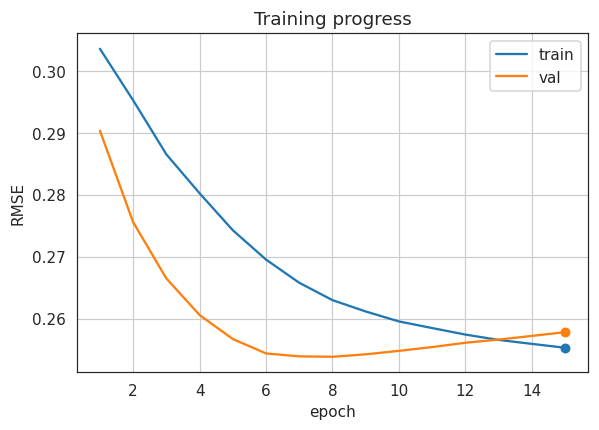

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.30357 MAE=0.24214 R2=-0.09695 | Acc=0.70052 Prec=0.35361 Rec=0.11884 F1=0.17790 AUROC=0.58905 | T_ACC=0.33972 T_P=0.33334 T_R=0.33972 T_F1=0.22291 T_AUC=0.51691
VALID→ RMSE=0.29034 MAE=0.19879 R2=-0.03752 | Acc=0.73558 Prec=0.75693 Rec=0.08405 F1=0.15130 AUROC=0.73031 | T_ACC=0.40488 T_P=0.33361 T_R=0.40488 T_F1=0.28563 T_AUC=0.60644


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.29525 MAE=0.23607 R2=-0.03767 | Acc=0.72881 Prec=0.50545 Rec=0.24815 F1=0.33288 AUROC=0.66305 | T_ACC=0.34875 T_P=0.33335 T_R=0.34875 T_F1=0.22437 T_AUC=0.53221
VALID→ RMSE=0.27557 MAE=0.19006 R2=0.06536 | Acc=0.75417 Prec=0.66395 Rec=0.24977 F1=0.36299 AUROC=0.74322 | T_ACC=0.45709 T_P=0.33364 T_R=0.45709 T_F1=0.31327 T_AUC=0.64225


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.28652 MAE=0.22862 R2=0.02281 | Acc=0.74123 Prec=0.55006 Rec=0.27972 F1=0.37085 AUROC=0.68984 | T_ACC=0.36356 T_P=0.33336 T_R=0.36356 T_F1=0.23568 T_AUC=0.53914
VALID→ RMSE=0.26647 MAE=0.18767 R2=0.12605 | Acc=0.75639 Prec=0.64266 Rec=0.29570 F1=0.40503 AUROC=0.74421 | T_ACC=0.42853 T_P=0.33365 T_R=0.42853 T_F1=0.32208 T_AUC=0.63427


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.28024 MAE=0.22434 R2=0.06520 | Acc=0.74820 Prec=0.57472 Rec=0.29406 F1=0.38906 AUROC=0.70695 | T_ACC=0.36636 T_P=0.33335 T_R=0.36636 T_F1=0.24183 T_AUC=0.55211
VALID→ RMSE=0.26057 MAE=0.18739 R2=0.16432 | Acc=0.75649 Prec=0.62823 Rec=0.32243 F1=0.42615 AUROC=0.74342 | T_ACC=0.40677 T_P=0.33368 T_R=0.40677 T_F1=0.32456 T_AUC=0.61892


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.27427 MAE=0.21980 R2=0.10459 | Acc=0.75313 Prec=0.59247 Rec=0.30295 F1=0.40090 AUROC=0.72134 | T_ACC=0.35126 T_P=0.33336 T_R=0.35126 T_F1=0.24575 T_AUC=0.56745
VALID→ RMSE=0.25669 MAE=0.18862 R2=0.18902 | Acc=0.75555 Prec=0.61713 Rec=0.33793 F1=0.43672 AUROC=0.74154 | T_ACC=0.39273 T_P=0.33386 T_R=0.39273 T_F1=0.32609 T_AUC=0.59744


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.26953 MAE=0.21666 R2=0.13528 | Acc=0.75644 Prec=0.60337 Rec=0.31143 F1=0.41081 AUROC=0.73289 | T_ACC=0.36988 T_P=0.33336 T_R=0.36988 T_F1=0.24903 T_AUC=0.56053
VALID→ RMSE=0.25436 MAE=0.19080 R2=0.20367 | Acc=0.75330 Prec=0.60135 Rec=0.35675 F1=0.44782 AUROC=0.73984 | T_ACC=0.36821 T_P=0.33384 T_R=0.36821 T_F1=0.32664 T_AUC=0.58285


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.26578 MAE=0.21393 R2=0.15914 | Acc=0.75912 Prec=0.61208 Rec=0.31812 F1=0.41865 AUROC=0.74102 | T_ACC=0.36008 T_P=0.33336 T_R=0.36008 T_F1=0.25352 T_AUC=0.55573
VALID→ RMSE=0.25389 MAE=0.19289 R2=0.20660 | Acc=0.75100 Prec=0.58734 Rec=0.37672 F1=0.45902 AUROC=0.73893 | T_ACC=0.34207 T_P=0.33385 T_R=0.34207 T_F1=0.32606 T_AUC=0.58360


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.26298 MAE=0.21159 R2=0.17680 | Acc=0.76112 Prec=0.61808 Rec=0.32411 F1=0.42524 AUROC=0.74721 | T_ACC=0.38525 T_P=0.33338 T_R=0.38525 T_F1=0.25792 T_AUC=0.57010
VALID→ RMSE=0.25382 MAE=0.19442 R2=0.20705 | Acc=0.74794 Prec=0.57394 Rec=0.39252 F1=0.46621 AUROC=0.73835 | T_ACC=0.33207 T_P=0.33330 T_R=0.33207 T_F1=0.32437 T_AUC=0.59253


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.26114 MAE=0.21009 R2=0.18823 | Acc=0.76297 Prec=0.62378 Rec=0.32919 F1=0.43095 AUROC=0.75175 | T_ACC=0.37083 T_P=0.33337 T_R=0.37083 T_F1=0.26083 T_AUC=0.58181
VALID→ RMSE=0.25422 MAE=0.19591 R2=0.20455 | Acc=0.74460 Prec=0.56240 Rec=0.40198 F1=0.46885 AUROC=0.73674 | T_ACC=0.33818 T_P=0.33331 T_R=0.33818 T_F1=0.32333 T_AUC=0.59438


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.25954 MAE=0.20874 R2=0.19818 | Acc=0.76441 Prec=0.62691 Rec=0.33576 F1=0.43731 AUROC=0.75559 | T_ACC=0.38781 T_P=0.33338 T_R=0.38781 T_F1=0.26368 T_AUC=0.57892
VALID→ RMSE=0.25478 MAE=0.19752 R2=0.20106 | Acc=0.74021 Prec=0.54910 Rec=0.41127 F1=0.47030 AUROC=0.73469 | T_ACC=0.33665 T_P=0.33331 T_R=0.33665 T_F1=0.32251 T_AUC=0.59219


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.25847 MAE=0.20810 R2=0.20479 | Acc=0.76543 Prec=0.62948 Rec=0.33953 F1=0.44112 AUROC=0.75870 | T_ACC=0.35629 T_P=0.33336 T_R=0.35629 T_F1=0.26639 T_AUC=0.57268
VALID→ RMSE=0.25539 MAE=0.19857 R2=0.19723 | Acc=0.73572 Prec=0.53669 Rec=0.42102 F1=0.47187 AUROC=0.73236 | T_ACC=0.34220 T_P=0.33332 T_R=0.34220 T_F1=0.32114 T_AUC=0.58674


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.25741 MAE=0.20734 R2=0.21126 | Acc=0.76686 Prec=0.63337 Rec=0.34410 F1=0.44593 AUROC=0.76142 | T_ACC=0.36806 T_P=0.33337 T_R=0.36806 T_F1=0.26779 T_AUC=0.56766
VALID→ RMSE=0.25609 MAE=0.19953 R2=0.19284 | Acc=0.73230 Prec=0.52825 Rec=0.42417 F1=0.47053 AUROC=0.73028 | T_ACC=0.34827 T_P=0.33333 T_R=0.34827 T_F1=0.32005 T_AUC=0.58659


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.25655 MAE=0.20688 R2=0.21655 | Acc=0.76778 Prec=0.63535 Rec=0.34802 F1=0.44970 AUROC=0.76374 | T_ACC=0.36060 T_P=0.33336 T_R=0.36060 T_F1=0.27007 T_AUC=0.55611
VALID→ RMSE=0.25660 MAE=0.20078 R2=0.18960 | Acc=0.72863 Prec=0.51923 Rec=0.43569 F1=0.47381 AUROC=0.72863 | T_ACC=0.33953 T_P=0.33331 T_R=0.33953 T_F1=0.31969 T_AUC=0.58292


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.25591 MAE=0.20667 R2=0.22043 | Acc=0.76881 Prec=0.63758 Rec=0.35231 F1=0.45384 AUROC=0.76599 | T_ACC=0.39048 T_P=0.33338 T_R=0.39048 T_F1=0.27053 T_AUC=0.58809
VALID→ RMSE=0.25719 MAE=0.20202 R2=0.18585 | Acc=0.72603 Prec=0.51349 Rec=0.43808 F1=0.47280 AUROC=0.72736 | T_ACC=0.33928 T_P=0.33331 T_R=0.33928 T_F1=0.31956 T_AUC=0.58543


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Early stopping at epoch 15
✅ Final‐best model saved: AAPL_0.25382_fin.pth


[I 2025-10-02 23:14:13,718] Trial 1 finished with value: 0.253822386264801 and parameters: {'look_back': 90, 'SHORT_UNITS': 64, 'LONG_UNITS': 128, 'DROPOUT_SHORT': 0.2649767243091863, 'DROPOUT_LONG': 0.46911825065357937, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.16846708490191792, 'CONV_K': 5, 'CONV_DILATION': 1, 'SMOOTH_K': 3, 'SMOOTH_DILATION': 1, 'INITIAL_LR': 0.00012165772912747051, 'ETA_MIN': 1.51527114426394e-06, 'WEIGHT_DECAY': 0.000964191742523358, 'CLIPNORM': 2.383970593586061, 'CLS_LOSS_WEIGHT': 0.9659223600571134, 'SMOOTH_ALPHA': 0.00019195922186978823, 'SMOOTH_BETA': 23.9420564732209, 'SMOOTH_DELTA': 0.005626696945102439, 'DIFF1_WEIGHT': 0.2157728739028939, 'DIFF2_WEIGHT': 0.42255237642334664}. Best is trial 1 with value: 0.253822386264801.



▶ Trial 2 hyperparams:
{'look_back': 60, 'SHORT_UNITS': 128, 'LONG_UNITS': 192, 'DROPOUT_SHORT': 0.310008795636579, 'DROPOUT_LONG': 0.4467790104878421, 'ATT_HEADS': 8, 'ATT_DROPOUT': 0.3218026425628556, 'CONV_K': 4, 'CONV_DILATION': 2, 'SMOOTH_K': 3, 'SMOOTH_DILATION': 1, 'INITIAL_LR': 1.5829379914450848e-05, 'ETA_MIN': 2.369327078804e-06, 'WEIGHT_DECAY': 0.0051336626936084396, 'CLIPNORM': 0.7283671666228748, 'CLS_LOSS_WEIGHT': 0.036097515039519364, 'SMOOTH_ALPHA': 0.0029949679943412967, 'SMOOTH_BETA': 44.79602623415941, 'SMOOTH_DELTA': 0.004962374490857956, 'DIFF1_WEIGHT': 1.210771885410859, 'DIFF2_WEIGHT': 0.9763865489594185}

Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Preparing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing days:   0%|          | 0/5400 [00:00<?, ?it/s]

Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

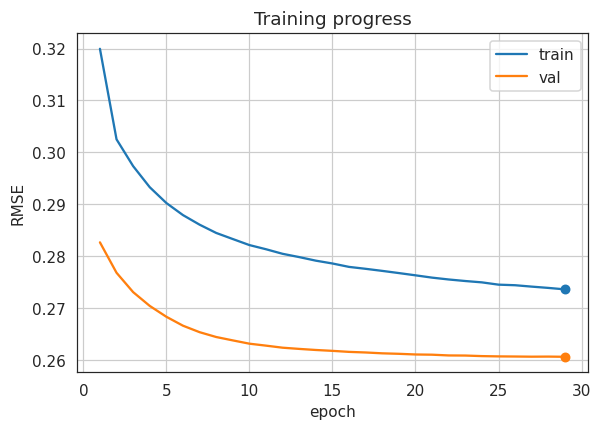

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.31996 MAE=0.27462 R2=-0.21331 | Acc=0.68858 Prec=0.33359 Rec=0.12605 F1=0.18296 AUROC=0.54292 | T_ACC=0.31413 T_P=0.33332 T_R=0.31413 T_F1=0.18645 T_AUC=0.47148
VALID→ RMSE=0.28267 MAE=0.20526 R2=0.03001 | Acc=0.71273 Prec=0.59184 Rec=0.00030 F1=0.00060 AUROC=0.61922 | T_ACC=0.23510 T_P=0.33322 T_R=0.23510 T_F1=0.17372 T_AUC=0.30662


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.30251 MAE=0.24962 R2=-0.08464 | Acc=0.70592 Prec=0.35071 Rec=0.07406 F1=0.12229 AUROC=0.54687 | T_ACC=0.32124 T_P=0.33333 T_R=0.32124 T_F1=0.19376 T_AUC=0.46343
VALID→ RMSE=0.27681 MAE=0.20349 R2=0.06981 | Acc=0.71271 Prec=1.00000 Rec=0.00001 F1=0.00002 AUROC=0.63252 | T_ACC=0.25711 T_P=0.33325 T_R=0.25711 T_F1=0.20622 T_AUC=0.30183


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.29735 MAE=0.24592 R2=-0.04794 | Acc=0.71162 Prec=0.36101 Rec=0.05516 F1=0.09570 AUROC=0.54741 | T_ACC=0.28946 T_P=0.33331 T_R=0.28946 T_F1=0.20154 T_AUC=0.44953
VALID→ RMSE=0.27308 MAE=0.20224 R2=0.09471 | Acc=0.71271 Prec=0.83333 Rec=0.00005 F1=0.00010 AUROC=0.64707 | T_ACC=0.28292 T_P=0.33327 T_R=0.28292 T_F1=0.22960 T_AUC=0.29952


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.29329 MAE=0.24272 R2=-0.01951 | Acc=0.71410 Prec=0.37662 Rec=0.05112 F1=0.09003 AUROC=0.55332 | T_ACC=0.30375 T_P=0.33332 T_R=0.30375 T_F1=0.20718 T_AUC=0.48767
VALID→ RMSE=0.27043 MAE=0.20153 R2=0.11224 | Acc=0.71288 Prec=0.88608 Rec=0.00072 F1=0.00144 AUROC=0.66129 | T_ACC=0.28725 T_P=0.33327 T_R=0.28725 T_F1=0.24925 T_AUC=0.29768


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.29025 MAE=0.24038 R2=0.00154 | Acc=0.71625 Prec=0.39741 Rec=0.04984 F1=0.08857 AUROC=0.56108 | T_ACC=0.32054 T_P=0.33332 T_R=0.32054 T_F1=0.21238 T_AUC=0.47434
VALID→ RMSE=0.26834 MAE=0.20117 R2=0.12590 | Acc=0.71322 Prec=0.91038 Rec=0.00198 F1=0.00396 AUROC=0.67374 | T_ACC=0.30710 T_P=0.33328 T_R=0.30710 T_F1=0.26427 T_AUC=0.29595


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.28792 MAE=0.23887 R2=0.01747 | Acc=0.71784 Prec=0.41632 Rec=0.04967 F1=0.08875 AUROC=0.56855 | T_ACC=0.32760 T_P=0.33334 T_R=0.32760 T_F1=0.21668 T_AUC=0.47571
VALID→ RMSE=0.26662 MAE=0.20127 R2=0.13707 | Acc=0.71402 Prec=0.91280 Rec=0.00506 F1=0.01006 AUROC=0.68408 | T_ACC=0.31918 T_P=0.33329 T_R=0.31918 T_F1=0.27961 T_AUC=0.29416


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.28608 MAE=0.23769 R2=0.03001 | Acc=0.71912 Prec=0.43396 Rec=0.05040 F1=0.09030 AUROC=0.57684 | T_ACC=0.30876 T_P=0.33331 T_R=0.30876 T_F1=0.22116 T_AUC=0.47127
VALID→ RMSE=0.26537 MAE=0.20147 R2=0.14513 | Acc=0.71514 Prec=0.90402 Rec=0.00949 F1=0.01877 AUROC=0.69222 | T_ACC=0.33919 T_P=0.33330 T_R=0.33919 T_F1=0.29266 T_AUC=0.29315


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.28449 MAE=0.23660 R2=0.04079 | Acc=0.72017 Prec=0.44988 Rec=0.05191 F1=0.09309 AUROC=0.58447 | T_ACC=0.33338 T_P=0.33333 T_R=0.33338 T_F1=0.22556 T_AUC=0.48687
VALID→ RMSE=0.26444 MAE=0.20164 R2=0.15112 | Acc=0.71634 Prec=0.88459 Rec=0.01457 F1=0.02867 AUROC=0.69880 | T_ACC=0.33719 T_P=0.33330 T_R=0.33719 T_F1=0.30342 T_AUC=0.29247


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.28331 MAE=0.23603 R2=0.04869 | Acc=0.72163 Prec=0.47297 Rec=0.05492 F1=0.09842 AUROC=0.59219 | T_ACC=0.31900 T_P=0.33333 T_R=0.31900 T_F1=0.22924 T_AUC=0.50293
VALID→ RMSE=0.26379 MAE=0.20172 R2=0.15530 | Acc=0.71772 Prec=0.86486 Rec=0.02072 F1=0.04047 AUROC=0.70401 | T_ACC=0.35028 T_P=0.33332 T_R=0.35028 T_F1=0.31105 T_AUC=0.29211


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.28215 MAE=0.23510 R2=0.05649 | Acc=0.72237 Prec=0.48526 Rec=0.05902 F1=0.10524 AUROC=0.60017 | T_ACC=0.30621 T_P=0.33331 T_R=0.30621 T_F1=0.23243 T_AUC=0.48364
VALID→ RMSE=0.26315 MAE=0.20213 R2=0.15935 | Acc=0.71923 Prec=0.85811 Rec=0.02722 F1=0.05277 AUROC=0.70834 | T_ACC=0.36063 T_P=0.33333 T_R=0.36063 T_F1=0.31688 T_AUC=0.29257


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.28134 MAE=0.23470 R2=0.06185 | Acc=0.72339 Prec=0.50029 Rec=0.06216 F1=0.11057 AUROC=0.60724 | T_ACC=0.31640 T_P=0.33332 T_R=0.31640 T_F1=0.23568 T_AUC=0.47492
VALID→ RMSE=0.26278 MAE=0.20219 R2=0.16176 | Acc=0.72079 Prec=0.85251 Rec=0.03404 F1=0.06546 AUROC=0.71200 | T_ACC=0.35964 T_P=0.33334 T_R=0.35964 T_F1=0.32169 T_AUC=0.29323


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.28046 MAE=0.23402 R2=0.06772 | Acc=0.72448 Prec=0.51554 Rec=0.06704 F1=0.11866 AUROC=0.61439 | T_ACC=0.31989 T_P=0.33333 T_R=0.31989 T_F1=0.23947 T_AUC=0.48444
VALID→ RMSE=0.26238 MAE=0.20256 R2=0.16429 | Acc=0.72222 Prec=0.84037 Rec=0.04090 F1=0.07801 AUROC=0.71531 | T_ACC=0.36626 T_P=0.33337 T_R=0.36626 T_F1=0.32526 T_AUC=0.29505


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.27983 MAE=0.23377 R2=0.07191 | Acc=0.72574 Prec=0.53126 Rec=0.07277 F1=0.12801 AUROC=0.62143 | T_ACC=0.33808 T_P=0.33333 T_R=0.33808 T_F1=0.24282 T_AUC=0.48395
VALID→ RMSE=0.26215 MAE=0.20277 R2=0.16577 | Acc=0.72368 Prec=0.83188 Rec=0.04790 F1=0.09058 AUROC=0.71808 | T_ACC=0.37088 T_P=0.33341 T_R=0.37088 T_F1=0.32775 T_AUC=0.29704


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.27914 MAE=0.23322 R2=0.07647 | Acc=0.72659 Prec=0.54021 Rec=0.07835 F1=0.13685 AUROC=0.62782 | T_ACC=0.33228 T_P=0.33333 T_R=0.33228 T_F1=0.24663 T_AUC=0.49495
VALID→ RMSE=0.26194 MAE=0.20295 R2=0.16709 | Acc=0.72514 Prec=0.82197 Rec=0.05528 F1=0.10359 AUROC=0.72061 | T_ACC=0.36471 T_P=0.33344 T_R=0.36471 T_F1=0.32967 T_AUC=0.29888


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.27860 MAE=0.23283 R2=0.08007 | Acc=0.72740 Prec=0.54697 Rec=0.08494 F1=0.14705 AUROC=0.63410 | T_ACC=0.30188 T_P=0.33330 T_R=0.30188 T_F1=0.25003 T_AUC=0.45963
VALID→ RMSE=0.26177 MAE=0.20308 R2=0.16816 | Acc=0.72668 Prec=0.81476 Rec=0.06297 F1=0.11690 AUROC=0.72300 | T_ACC=0.35711 T_P=0.33344 T_R=0.35711 T_F1=0.33081 T_AUC=0.30206


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ RMSE=0.27794 MAE=0.23224 R2=0.08439 | Acc=0.72856 Prec=0.55737 Rec=0.09116 F1=0.15669 AUROC=0.64025 | T_ACC=0.32791 T_P=0.33334 T_R=0.32791 T_F1=0.25314 T_AUC=0.48597
VALID→ RMSE=0.26157 MAE=0.20332 R2=0.16941 | Acc=0.72805 Prec=0.80918 Rec=0.06990 F1=0.12869 AUROC=0.72522 | T_ACC=0.35875 T_P=0.33351 T_R=0.35875 T_F1=0.33178 T_AUC=0.30553


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ RMSE=0.27757 MAE=0.23210 R2=0.08683 | Acc=0.72981 Prec=0.56735 Rec=0.09816 F1=0.16736 AUROC=0.64599 | T_ACC=0.34147 T_P=0.33334 T_R=0.34147 T_F1=0.25627 T_AUC=0.49059
VALID→ RMSE=0.26146 MAE=0.20362 R2=0.17014 | Acc=0.72940 Prec=0.80332 Rec=0.07698 F1=0.14050 AUROC=0.72718 | T_ACC=0.35010 T_P=0.33350 T_R=0.35010 T_F1=0.33233 T_AUC=0.30943


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ RMSE=0.27717 MAE=0.23185 R2=0.08946 | Acc=0.73064 Prec=0.57115 Rec=0.10552 F1=0.17813 AUROC=0.65082 | T_ACC=0.35683 T_P=0.33335 T_R=0.35683 T_F1=0.25936 T_AUC=0.51238
VALID→ RMSE=0.26129 MAE=0.20388 R2=0.17118 | Acc=0.73057 Prec=0.78998 Rec=0.08473 F1=0.15305 AUROC=0.72905 | T_ACC=0.34108 T_P=0.33342 T_R=0.34108 T_F1=0.33258 T_AUC=0.31298


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ RMSE=0.27675 MAE=0.23159 R2=0.09222 | Acc=0.73190 Prec=0.57820 Rec=0.11408 F1=0.19056 AUROC=0.65614 | T_ACC=0.33922 T_P=0.33334 T_R=0.33922 T_F1=0.26194 T_AUC=0.49109
VALID→ RMSE=0.26120 MAE=0.20404 R2=0.17177 | Acc=0.73170 Prec=0.78273 Rec=0.09155 F1=0.16393 AUROC=0.73074 | T_ACC=0.34162 T_P=0.33348 T_R=0.34162 T_F1=0.33296 T_AUC=0.31607


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ RMSE=0.27632 MAE=0.23121 R2=0.09506 | Acc=0.73318 Prec=0.58523 Rec=0.12176 F1=0.20158 AUROC=0.66061 | T_ACC=0.30325 T_P=0.33332 T_R=0.30325 T_F1=0.26361 T_AUC=0.47328
VALID→ RMSE=0.26107 MAE=0.20422 R2=0.17259 | Acc=0.73314 Prec=0.77734 Rec=0.09970 F1=0.17674 AUROC=0.73227 | T_ACC=0.34203 T_P=0.33356 T_R=0.34203 T_F1=0.33332 T_AUC=0.31890


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ RMSE=0.27587 MAE=0.23088 R2=0.09797 | Acc=0.73441 Prec=0.59013 Rec=0.13068 F1=0.21398 AUROC=0.66566 | T_ACC=0.31323 T_P=0.33333 T_R=0.31323 T_F1=0.26578 T_AUC=0.46811
VALID→ RMSE=0.26103 MAE=0.20429 R2=0.17285 | Acc=0.73411 Prec=0.77028 Rec=0.10617 F1=0.18661 AUROC=0.73365 | T_ACC=0.34234 T_P=0.33368 T_R=0.34234 T_F1=0.33369 T_AUC=0.32191


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ RMSE=0.27552 MAE=0.23059 R2=0.10030 | Acc=0.73514 Prec=0.59140 Rec=0.13768 F1=0.22336 AUROC=0.66996 | T_ACC=0.32293 T_P=0.33334 T_R=0.32293 T_F1=0.26773 T_AUC=0.49157
VALID→ RMSE=0.26089 MAE=0.20450 R2=0.17377 | Acc=0.73514 Prec=0.76360 Rec=0.11309 F1=0.19701 AUROC=0.73488 | T_ACC=0.33275 T_P=0.33326 T_R=0.33275 T_F1=0.33301 T_AUC=0.32446


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ RMSE=0.27522 MAE=0.23046 R2=0.10224 | Acc=0.73629 Prec=0.59486 Rec=0.14647 F1=0.23506 AUROC=0.67337 | T_ACC=0.35248 T_P=0.33335 T_R=0.35248 T_F1=0.26901 T_AUC=0.50872
VALID→ RMSE=0.26087 MAE=0.20474 R2=0.17389 | Acc=0.73605 Prec=0.76006 Rec=0.11876 F1=0.20542 AUROC=0.73605 | T_ACC=0.33288 T_P=0.33326 T_R=0.33288 T_F1=0.33307 T_AUC=0.32692


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ RMSE=0.27496 MAE=0.23028 R2=0.10393 | Acc=0.73722 Prec=0.59710 Rec=0.15402 F1=0.24487 AUROC=0.67733 | T_ACC=0.31701 T_P=0.33333 T_R=0.31701 T_F1=0.27022 T_AUC=0.47086
VALID→ RMSE=0.26076 MAE=0.20485 R2=0.17458 | Acc=0.73702 Prec=0.75554 Rec=0.12514 F1=0.21471 AUROC=0.73717 | T_ACC=0.33299 T_P=0.33326 T_R=0.33299 T_F1=0.33313 T_AUC=0.32942


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ RMSE=0.27452 MAE=0.22990 R2=0.10679 | Acc=0.73825 Prec=0.59965 Rec=0.16184 F1=0.25489 AUROC=0.68025 | T_ACC=0.33410 T_P=0.33333 T_R=0.33410 T_F1=0.27137 T_AUC=0.48653
VALID→ RMSE=0.26070 MAE=0.20502 R2=0.17492 | Acc=0.73792 Prec=0.75183 Rec=0.13104 F1=0.22318 AUROC=0.73811 | T_ACC=0.33307 T_P=0.33326 T_R=0.33307 T_F1=0.33317 T_AUC=0.33242


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ RMSE=0.27441 MAE=0.22996 R2=0.10751 | Acc=0.73911 Prec=0.60007 Rec=0.17064 F1=0.26572 AUROC=0.68332 | T_ACC=0.34310 T_P=0.33335 T_R=0.34310 T_F1=0.27210 T_AUC=0.49424
VALID→ RMSE=0.26068 MAE=0.20530 R2=0.17508 | Acc=0.73870 Prec=0.74786 Rec=0.13649 F1=0.23085 AUROC=0.73898 | T_ACC=0.33315 T_P=0.33326 T_R=0.33315 T_F1=0.33321 T_AUC=0.33476


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ RMSE=0.27414 MAE=0.22976 R2=0.10926 | Acc=0.73981 Prec=0.60102 Rec=0.17687 F1=0.27331 AUROC=0.68590 | T_ACC=0.31580 T_P=0.33332 T_R=0.31580 T_F1=0.27306 T_AUC=0.50827
VALID→ RMSE=0.26065 MAE=0.20542 R2=0.17528 | Acc=0.73949 Prec=0.74530 Rec=0.14163 F1=0.23803 AUROC=0.73972 | T_ACC=0.33320 T_P=0.33326 T_R=0.33320 T_F1=0.33323 T_AUC=0.33636


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ RMSE=0.27390 MAE=0.22959 R2=0.11087 | Acc=0.74090 Prec=0.60407 Rec=0.18396 F1=0.28203 AUROC=0.68884 | T_ACC=0.32047 T_P=0.33333 T_R=0.32047 T_F1=0.27415 T_AUC=0.48189
VALID→ RMSE=0.26067 MAE=0.20564 R2=0.17517 | Acc=0.74007 Prec=0.74146 Rec=0.14627 F1=0.24433 AUROC=0.74046 | T_ACC=0.33323 T_P=0.33326 T_R=0.33323 T_F1=0.33325 T_AUC=0.33883


Epoch 29:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ RMSE=0.27362 MAE=0.22936 R2=0.11269 | Acc=0.74141 Prec=0.60350 Rec=0.19014 F1=0.28918 AUROC=0.69131 | T_ACC=0.33171 T_P=0.33335 T_R=0.33171 T_F1=0.27492 T_AUC=0.49806
VALID→ RMSE=0.26063 MAE=0.20571 R2=0.17541 | Acc=0.74061 Prec=0.73880 Rec=0.15028 F1=0.24975 AUROC=0.74105 | T_ACC=0.33326 T_P=0.33326 T_R=0.33326 T_F1=0.33326 T_AUC=0.34104


Epoch 30:   0%|          | 0/60 [00:00<?, ?batch/s]

eval:   0%|          | 0/751 [00:00<?, ?batch/s]

In [ ]:
# importlib.reload(dual_lstm) ########################

# ──────────────────────────────────────────────────────────────────────────────
#  Create Optuna study and run optimization
# ──────────────────────────────────────────────────────────────────────────────

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="minimize",
    pruner=MedianPruner(n_startup_trials=6, n_warmup_steps=12),
)

        
study.optimize(
    objective,
    n_trials = 100,
    n_jobs   = 1,
    callbacks=[live_cb, plots.cleanup_callback],
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep



In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
#  Print out the best hyperparameters & result
# ──────────────────────────────────────────────────────────────────────────────
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

# ──────────────────────────────────────────────────────────────────────────────
#  Compute and print parameter importances
# ──────────────────────────────────────────────────────────────────────────────
imps = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact on RMSE):")
for name, score in sorted(imps.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ──────────────────────────────────────────────────────────────────────────────
#  Dump study results to JSON
# ──────────────────────────────────────────────────────────────────────────────
# 1) Build your session‐only DataFrame once
session_df = df.between_time(params.regular_start,
                             params.regular_end)

# 2) Derive the trading‐day boundaries
first_day = session_df.index.normalize().min()
last_day  = session_df.index.normalize().max()

# 3) Format your file name
start_date = first_day.strftime("%Y%m%d")
end_date   = last_day.strftime("%Y%m%d")
file_name  = f"{params.ticker}_{start_date}-{end_date}_optuna_model_hpars.json"
file_path  = os.path.join(results_folder, file_name)


# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params": study.best_params,
            "best_value" : study.best_value,
            "importances": imps,
            "trials": [
                {"number": t.number, "value": t.value, "params": t.params, 
                 "state": t.state.name}
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
